# LSTM Timeseries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


## Show files, read data

In [2]:
os.chdir('/home/steven/Documents/IDR')
#os.listdir(os.getcwd())

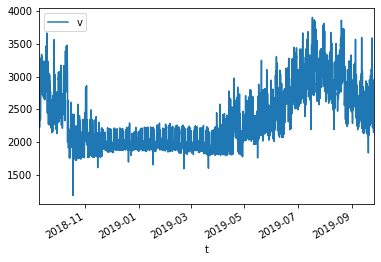

In [3]:
idr = pd.read_csv('CLP_51452223035_040812006_IDR_vert.csv', header = None)
idr.columns = ['t', 'v']
idr['t'] = pd.to_datetime(idr['t'])
idr.set_index('t', drop = True, inplace = True)
idr.plot(y = 'v')

In [4]:
n = idr.shape[0]
n_train = int(n*.8)

train = idr[:n_train]
test = idr[n_train:]

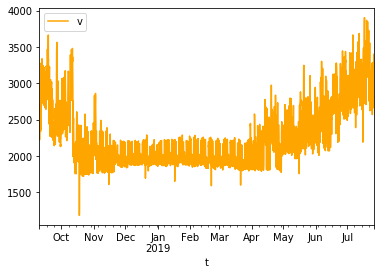

In [5]:
train.plot(y = 'v', color = 'orange')

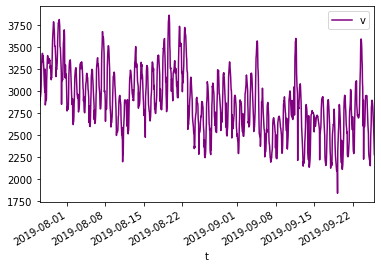

In [6]:
test.plot(y = 'v', color = 'purple')

## Preprocess for RNN
Scale between (0,1)

In [7]:
scaler = MinMaxScaler(feature_range = (0, 1))

train_scaled = scaler.fit_transform(train)
train.shape

(7680, 1)

Break features into batches of 60, using first sixty to predict 60th obs.

In [8]:
features_set = []
labels = []

for i in range(60, 7680):
    features_set.append(train_scaled[i-60:i, 0])
    labels.append(train_scaled[i, 0])

Reshape features set into 3d numpy array.

In [9]:
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
features_set.shape

(7620, 60, 1)

## Train model

In [10]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(features_set, labels, epochs = 10, batch_size = 32)

Epoch 1/10
7620/7620 [==============================] - 119s 16ms/step - loss: 0.0124
Epoch 2/10
7620/7620 [==============================] - 124s 16ms/step - loss: 0.0069
Epoch 3/10
1792/7620 [======>.......................] - ETA: 1:45 - loss: 0.0045

## Evaluate Model

In [31]:
test_inputs = idr[len(idr) - len(test) - 60:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

test_inputs.shape

(1980, 1)

In [34]:
test_features = []
for i in range(60, 1980):
    test_features.append(test_inputs[i-60:i, 0])
    
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
test_features.shape

(1920, 60, 1)

## Predictions

In [ ]:
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)

## Plot data

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(idr, color='blue', label='Actual')
plt.plot(predictions , color='red', label='Predicted')
plt.title('kWh')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()